# DATA 643: Recommender Systems
## Walt Wells, Summer 2017
Project 5: Implementing a Recommender System on Spark

# Assignment Requirements

_The goal of this project is give you practice beginning to work with a distributed recommender system. It is sufficient for this assignment to build out your application on a single node._

Adapt one of your recommendation systems to work with Apache Spark and compare the performance with your previous iteration. Consider the efficiency of the system and the added complexity of using Spark. You may complete the assignment using PySpark (Python), SparkR (R) , sparklyr (R), or Scala.

Please include in your conclusion: For your given recommender system’s data, algorithm(s), and (envisioned) implementation, at what point would you see moving to a distributed platform such as Spark becoming necessary?

You may work on any platform of your choosing, including Databricks Community Edition or in local mode. You are encouraged but not required to work in a small group on this project.

# Environment Prep

In [27]:
if (!require('sparklyr')) install.packages('sparklyr')
if (!require('dplyr')) install.packages('dplyr')
if (!require('reshape2')) install.packages('reshape2')
if (!require('ggplot2')) install.packages('ggplot2')
if (!require('XML')) install.packages('XML')

# Resources 

This Jupyter notebook is set up on a VM as part of an allocation grant from the [Open Science Data Cloud](https://www.opensciencedatacloud.org/). The OSDC offers services similar to commercial cloud providers like AWS, Azure and Google Compute, but is designed to serve the 'long tail' of the data science community by providing allocation grants to researchers in need of resources. I help manage the operations of the OSDC as part of my work with the [Open Commons Consortium](http://www.occ-data.org/).

Our full Jester Dataset is not too large and can be managed in the VM using ephemeral storage. I port forward the jupyter notebook through a proxy server and work in a browser on my local machine. Github is used to manage the code.

See the Spark section for more details on the specifics of this project. 

# Data Import

For this project we will use a subset of Dataset 2+ of the [Jester dataset](http://eigentaste.berkeley.edu/dataset/). 

This dataset is used courtesy of Dr. Ken Goldberg.  

__Publication Citation:__
Eigentaste: A Constant Time Collaborative Filtering Algorithm. Ken Goldberg, Theresa Roeder, Dhruv Gupta, and Chris Perkins. Information Retrieval, 4(2), 133-151. July 2001. 

To make it easier to import, the .zip file has been downloaded and the resulting .xls converted to a simple csv.  We also utilize the [joke .zip](http://eigentaste.berkeley.edu/dataset/jester_dataset_1_joke_texts.zip) in the final step. 

In [2]:
jester <- read.csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_643/master/Project2/jesterfinal151cols.csv", header=F)
jester <- jester[,2:101]# remove last 50 so it matches with our available joke text

# Data Prep

## Subset

Even though we'll be using Spark for this project, let's subset our data a bit to make it more managable, since we are just using Spark local instead of building a full cluster.

In [3]:
print("BeforeSubset: ")
dim(jester)
jester <- jester[1:10000,]
print("AfterSubset: ")
dim(jester)

[1] "BeforeSubset: "


[1] 50692   100

[1] "AfterSubset: "


[1] 10000   100

## NA Removal

In [4]:
jester[jester==99] <- NA
allNAs <- sapply(jester, function(x) all(is.na(x))) # remove cols with all NAs
table(allNAs)
jester <- jester[,!allNAs] 
#for this exercise we will leave the columns where every user ranked an item 

allNAs
FALSE  TRUE 
   90    10 

## Distribution Review 1:  Mean Joke Rating

0%        25%        50%        75%       100% 
-2.8296594  0.2812483  1.8440864  2.4936108  3.7059884

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


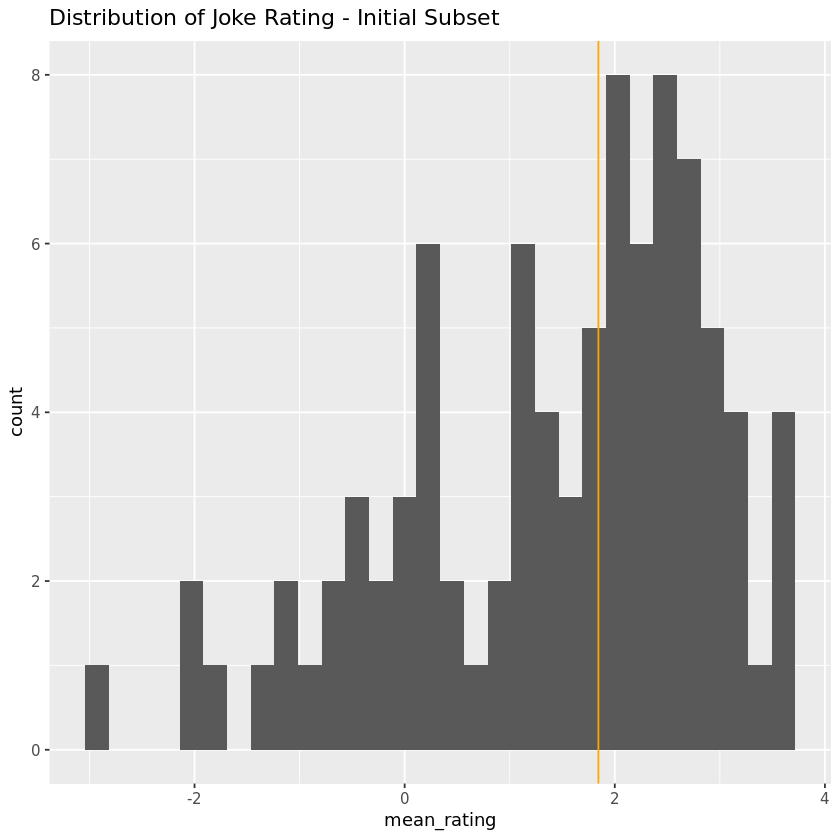

In [5]:
mean_rating <- colMeans(jester, na.rm=T)
quantile(mean_rating)
goodrating <- quantile(mean_rating, .5)
qplot(mean_rating) + ggtitle("Distribution of Joke Rating - Initial Subset") + 
    geom_vline(xintercept = goodrating, col='orange')

## Center and Scale

In [6]:
jesterScaled <- data.frame(scale(jester, 
                                center=T, 
                                scale=T))

#we'll also save our matrix names for later
ItemIndex <- names(jesterScaled)

## Distribution Review 2:  Mean Joke Rating, Center + Scaled

0%           25%           50%           75%          100% 
-8.081908e-17 -2.733871e-17 -4.338564e-19  2.079352e-17  7.085233e-17

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


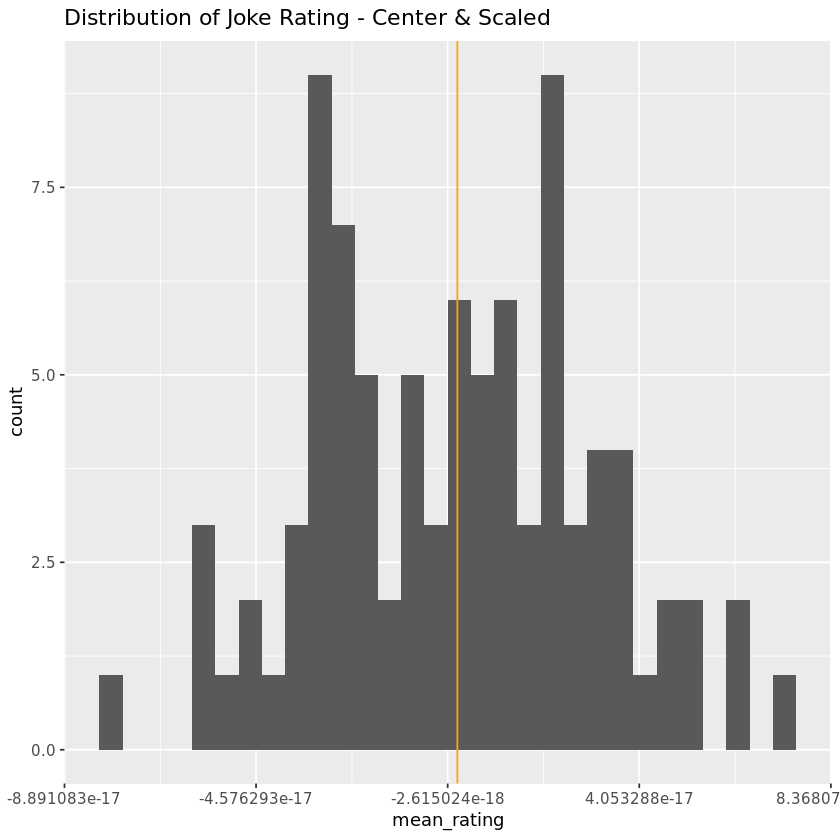

In [7]:
mean_rating <- colMeans(jesterScaled, na.rm=T)
quantile(mean_rating)
goodrating <- quantile(mean_rating, .5)
qplot(mean_rating) + ggtitle("Distribution of Joke Rating - Center & Scaled") + 
    geom_vline(xintercept = goodrating, col='orange')

## NA Review:  % Sparseness

In [8]:
sum(is.na(jesterScaled))/prod(dim(jesterScaled))

[1] 0.7477333

## NA Handling - ColMean Imputation

In [9]:
jMeans <- colMeans(jesterScaled, na.rm=TRUE)
indx <- which(is.na(jesterScaled), arr.ind=TRUE)
jesterScaled[indx] <- jMeans[indx[,2]]
head(jesterScaled)

V6,V8,V9,V14,V16,V17,V18,V19,V20,V21,⋯,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101
0.4154984,-1.17992871,-1.4462855,-1.01275974,0.4801107,-1.339563,-1.74536923,-1.2962743,-1.783526336,-1.489419,⋯,1.247052e+00,2.778971e-01,1.388627e+00,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-1.4111146,2.33498043,1.9820015,1.93684339,0.3948244,1.011809,1.51571067,-0.4306253,-1.932131148,-1.483913,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-1.4399255,-1.28280410,-1.0704268,-0.17474166,-1.4871600,-1.394502,-1.89260862,-1.7206121,-1.970658321,-1.081977,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
1.6486063,1.38624073,-0.8312440,0.11194874,-0.4125526,1.039279,0.91584648,1.0800171,0.825313700,1.076363,⋯,2.596330e-01,7.437882e-01,3.438061e-01,1.148643e-01,7.501635e-01,1.095785e+00,2.827096e-01,-2.576014e-01,-2.825814e-01,-8.223640e-02
0.3694009,-1.14563691,0.1710459,1.50680779,-0.9924994,-1.301106,-0.14754914,-1.6017975,0.396010910,-1.538973,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-0.1607202,0.08886776,0.1539614,0.01270976,0.7302839,0.429460,-0.01666968,0.1295005,0.005235292,0.118324,⋯,-1.779059e-01,1.787740e-17,-6.618698e-02,2.222633e-17,4.655672e-17,-3.306340e-01,-2.162044e-02,-5.550237e-18,-3.264701e-17,3.758568e-17


## Distribution Review 3:  Mean Joke Rating, Imputed Values

0%           25%           50%           75%          100% 
-8.135852e-17 -2.758449e-17 -2.141626e-19  2.086499e-17  7.078351e-17

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


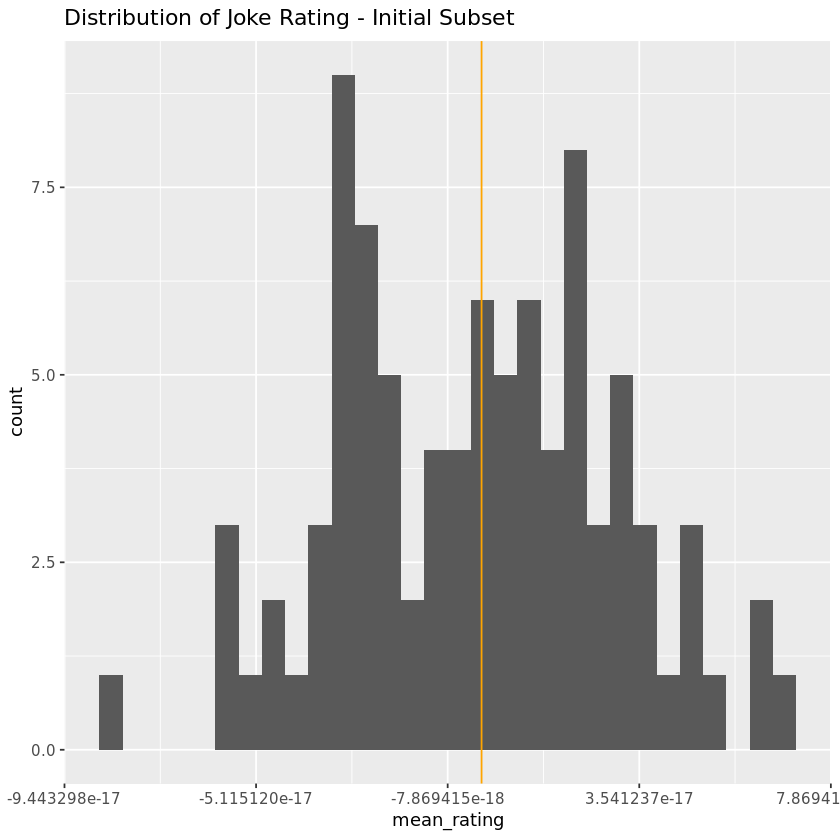

In [10]:
mean_rating <- colMeans(jesterScaled)
quantile(mean_rating)
goodrating <- quantile(mean_rating, .5)
qplot(mean_rating) + ggtitle("Distribution of Joke Rating - Initial Subset") + 
    geom_vline(xintercept = goodrating, col='orange')

## Update Col and Row Names

In order to use the Spark ML libraries, these need to be nums.   We will convert them now.

In [11]:
rownames(jesterScaled) <- 1:nrow(jesterScaled)
ItemIndex <- as.numeric(sub("V", "", ItemIndex))
colnames(jesterScaled) <- ItemIndex
head(jesterScaled)

6,8,9,14,16,17,18,19,20,21,⋯,92,93,94,95,96,97,98,99,100,101
0.4154984,-1.17992871,-1.4462855,-1.01275974,0.4801107,-1.339563,-1.74536923,-1.2962743,-1.783526336,-1.489419,⋯,1.247052e+00,2.778971e-01,1.388627e+00,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-1.4111146,2.33498043,1.9820015,1.93684339,0.3948244,1.011809,1.51571067,-0.4306253,-1.932131148,-1.483913,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-1.4399255,-1.28280410,-1.0704268,-0.17474166,-1.4871600,-1.394502,-1.89260862,-1.7206121,-1.970658321,-1.081977,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
1.6486063,1.38624073,-0.8312440,0.11194874,-0.4125526,1.039279,0.91584648,1.0800171,0.825313700,1.076363,⋯,2.596330e-01,7.437882e-01,3.438061e-01,1.148643e-01,7.501635e-01,1.095785e+00,2.827096e-01,-2.576014e-01,-2.825814e-01,-8.223640e-02
0.3694009,-1.14563691,0.1710459,1.50680779,-0.9924994,-1.301106,-0.14754914,-1.6017975,0.396010910,-1.538973,⋯,3.243232e-18,1.787740e-17,-1.710016e-17,2.222633e-17,4.655672e-17,8.955273e-18,7.085233e-17,-5.550237e-18,-3.264701e-17,3.758568e-17
-0.1607202,0.08886776,0.1539614,0.01270976,0.7302839,0.429460,-0.01666968,0.1295005,0.005235292,0.118324,⋯,-1.779059e-01,1.787740e-17,-6.618698e-02,2.222633e-17,4.655672e-17,-3.306340e-01,-2.162044e-02,-5.550237e-18,-3.264701e-17,3.758568e-17


## Convert from Wide to Long

In [12]:
jesterLong <- melt(as.matrix(jesterScaled))
names(jesterLong) <- c("user", "item", "rating")
head(jesterLong)
dim(jesterLong)

user,item,rating
1,6,0.4154984
2,6,-1.4111146
3,6,-1.4399255
4,6,1.6486063
5,6,0.3694009
6,6,-0.1607202


[1] 900000      3

# Spark 

For the purposes of this exercise, we will use a large VM, tell spark to use all the cores, and treat this as a baby development environment for managing Spark.   Future projects may include bringing up a full spark cluster instead of a single machine with the necessary tools.

## Start Timer

In [13]:
ptm <- proc.time()

## Config and Connect

In [14]:
Sys.setenv(JAVA_HOME = "/usr/lib/jvm/java-7-openjdk-amd64/jre")
#Sys.getenv("JAVA_HOME")
Sys.setenv(SPARK_HOME = "/home/ubuntu/.cache/spark/spark-1.6.2-bin-hadoop2.6")
#spark_home_dir()
#spark_installed_versions()

config <- spark_config()
#config$sparklyr.shell.driver.memory <- "4G"
#config$sparklyr.shell.executor.memory <- "4G"
#config$sparklyr.cores.local <- 8
#config$spark.sql.shuffle.partitions.local <- 2001
#config$spark.yarn.executor.memoryOverhead <- "1g"

sc <- spark_connect(master = "local[*]", config = config)

## Load Data

In [15]:
jester_tbl <- sdf_copy_to(sc, jesterLong, 'jester_tbl', overwrite=TRUE)
jester_tbl

# Source:   table<jester_tbl> [?? x 3]
# Database: spark_connection
    user  item     rating
   <int> <int>      <dbl>
 1     1     6  0.4154984
 2     2     6 -1.4111146
 3     3     6 -1.4399255
 4     4     6  1.6486063
 5     5     6  0.3694009
 6     6     6 -0.1607202
 7     7     6  1.5218382
 8     8     6  1.8963803
 9     9     6 -0.6850791
10    10     6 -0.9443775
# ... with 9e+05 more rows

# Model

## ALS Factorization

In [16]:
explicit_model <- ml_als_factorization(jester_tbl, 
                                       rating.column = "rating", 
                                       user.column = "user",
                                       item.column = "item")
summary(explicit_model)

                 Length Class      Mode       
item.factors     11     data.frame list       
user.factors     11     data.frame list       
data              2     spark_jobj environment
ml.options        6     ml_options list       
model.parameters  2     -none-     list       
.call             5     -none-     call       
.model            2     spark_jobj environment

## Make Predictions

In [17]:
predictions <- explicit_model$.model %>%
    invoke("transform", spark_dataframe(jester_tbl)) %>%
    collect()

mypred <- data.frame(predictions)
mypred[1:10,]

user,item,rating,prediction
7,23,1.057460e+00,0.013365468
15,23,4.759148e-18,0.085968822
23,23,4.759148e-18,-0.001698845
31,23,4.759148e-18,0.051732630
39,23,4.759148e-18,0.070192829
47,23,4.759148e-18,-0.003583969
55,23,4.759148e-18,0.007726795
63,23,4.759148e-18,0.025028076
71,23,4.759148e-18,0.019135986
79,23,4.759148e-18,0.008001506


In [18]:
item.factors <- explicit_model$item.factors
user.factors <- explicit_model$user.factors
usertopredict <- user.factors[sample(1:nrow(jesterScaled),1), ]
usertopredict

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
8209,8209,-0.004788418,-0.1040003,0.002085974,0.06414935,0.09893,-0.007285535,0.007995718,0.1057781,-0.03151909,0.03412427


## RMSE

In [19]:
sqrt(mean((mypred$rating-mypred$prediction)^2))

[1] 0.445333

# Recommend

## Long to Wide

In [20]:
mypredsub <- subset(mypred, select = -c(rating) )
predWide <- reshape(mypredsub, idvar = "user", timevar = "item", direction = "wide") %>%
    arrange(user)
predWide <- predWide[,2:ncol(predWide)]
dim(predWide)
head(predWide)

[1] 10000    90

prediction.23,prediction.31,prediction.39,prediction.47,prediction.55,prediction.63,prediction.71,prediction.79,prediction.87,prediction.95,⋯,prediction.22,prediction.30,prediction.38,prediction.46,prediction.54,prediction.62,prediction.70,prediction.78,prediction.86,prediction.94
0.05615517,0.05082076,0.06403974,0.05592159,0.07090876,0.07509875,0.06514550,0.06219769,0.04497261,0.04565288,⋯,0.05321580,0.06336978,0.04320074,0.05839832,0.06448778,0.008848512,0.08261795,0.06133762,0.04567208,0.07872505
0.05128326,0.05463702,0.05056295,0.05184392,0.05631911,0.07034279,0.05510811,0.06191062,0.04839879,0.05671285,⋯,0.07401517,0.06400310,0.05332178,0.05572774,0.09465183,0.007892246,0.07317279,0.05108503,0.05028581,0.06874856
-0.06081278,-0.06642985,-0.05876690,-0.06176578,-0.06613295,-0.08501925,-0.06540196,-0.07493825,-0.05844760,-0.06992200,⋯,-0.09326705,-0.07779347,-0.06538142,-0.06665988,-0.12135659,-0.009430147,-0.08865504,-0.06048110,-0.06136044,-0.08302406
0.07101019,0.07278206,0.07309171,0.07162258,0.08175793,0.09779701,0.07858922,0.08434819,0.06412922,0.07301992,⋯,0.09395625,0.08702207,0.06849197,0.07640637,0.12017187,0.011082107,0.10400355,0.07317577,0.06665094,0.09801082
-0.07178781,-0.07322251,-0.07419791,-0.07235932,-0.08291574,-0.09866697,-0.07955003,-0.08500013,-0.06455377,-0.07319944,⋯,-0.09383835,-0.08764000,-0.06870005,-0.07712889,-0.11973710,-0.011201037,-0.10501070,-0.07410499,-0.06700680,-0.09901130
-0.05019757,-0.04893268,-0.05398979,-0.05035898,-0.06010565,-0.06826287,-0.05664934,-0.05792908,-0.04319863,-0.04710827,⋯,-0.05852740,-0.05946356,-0.04433725,-0.05325322,-0.07348292,-0.007862659,-0.07359621,-0.05300052,-0.04448594,-0.06968167


## Get Joke Helper Function

In [21]:
getJoke <- function(recnum) {
    # get a recommended joke from the zip file w/o unzipping only in mem
    recnum <- as.numeric(gsub("prediction.", "", recnum))
    filename <- paste0('jokes/init', recnum, '.html')
    joke <- readLines(unz('../Project2/jester_dataset_1_joke_texts.zip', filename))
    # inspired by: http://www.quantumforest.com/2011/10/reading-html-pages-in-r-for-text-processing/
    html <- htmlTreeParse(joke,useInternal = TRUE)
    text <- unlist(xpathApply(html, '//td', xmlValue))
    text <- gsub('\n', ' ', text)
    text <- sub("^[^a-zA-Z]*", "", text)
    text <- gsub('  ', ' ', text)
    text <- gsub("\\\"", "'", text)
    text <- paste(text, collapse = ' ')
}

## Get Sample User

In [22]:
usertopredict <- as.data.frame(t(predWide[sample(1:nrow(predWide),1), ]))
names(usertopredict) <- 'rating'
usertopredict$item<-rownames(usertopredict)
head(usertopredict)

,rating,item
prediction.23,0.01502153,prediction.23
prediction.31,0.01717474,prediction.31
prediction.39,0.01384922,prediction.39
prediction.47,0.01535112,prediction.47
prediction.55,0.01573117,prediction.55
prediction.63,0.02138688,prediction.63


## Make Predictions for Sample User

In [23]:
n <- 5
usertopredict <- arrange(usertopredict, desc(rating))
top_rec <- usertopredict[1,2]
top_rec
head(usertopredict, n)

[1] "prediction.16"

rating,item
0.2505300,prediction.16
0.2416209,prediction.19
0.2376796,prediction.17
0.2273580,prediction.9
0.2251453,prediction.14


## Get Joke

In [24]:
print(paste0("Recommended Joke: ", top_rec))
print(getJoke(top_rec))

[1] "Recommended Joke: prediction.16"
[1] " Q. What is orange and sounds like a parrot?  A. A carrot.    "


# Stop Timer

In [25]:
finaltime <- proc.time() - ptm
finaltime 

   user  system elapsed 
 15.443   0.279  79.956 

# Spark Disconnect

In [26]:
spark_disconnect(sc)

# References

* [Building a Recommendation System with R by Suresh K. Gorakala, Michele Usuelli](https://www.amazon.com/dp/B012O8S1YM/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)
* https://github.com/wwells/CUNY_DATA_643/
* [Mining of Massive Datasets, Anand Rajaraman and Jeffrey Ullman, Chapter 11.3](http://infolab.stanford.edu/~ullman/mmds/book.pdf)
* https://rpubs.com/chezou/sparklyr-als
* https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea